# INTRODUCTION

The dataset used in this work is the <a href="https://archive.ics.uci.edu/ml/datasets/HTRU2" target="_blank">HTRU2 Data Set</a>.<br>

HTRU2 is a data set which describes a sample of pulsar candidates collected during the **High Time Resolution Universe Survey** (South). 
	
Pulsars are a rare type of Neutron Star (this <a href="https://www.youtube.com/watch?v=hCwDNXKlN8Q" target="_blank">video</a> shows an overview of what a Neutron Star is) that produce radio emission detectable here on Earth. Pulsar astronomers have now detected over 1500 pulsars and expect to discover thousands more during the next few years. 


<img src="https://drive.google.com/uc?export=view&id=1xAnq9BBZlpuw_5cPbpCW7VGhZJ2Qyt9y" width="450" height="250" hspace="50">
  <figure>
  <figcaption>This animation shows a spinning pulsar, with its magnetic field rotating along with it. </figcaption>
</figure>


As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. 

Each pulse is found to be made up of radio waves of different frequencies. It is observed that the highest frequencies of a pulse arrive at a telescope slightly before the lower frequencies. The reason for this is that the pulse has been travelling through the *interstellar medium* (the space between the pulsar and the Earth) and the different frequencies making up the pulse travel at different speeds through this medium. This is referred to as the pulse dispersion and is due to the free electrons in the interstellar medium. 



	
Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. Classification systems in particular are being widely adopted, which treat the candidate data sets  as binary classification problems. 
Here the legitimate **pulsar examples** are a **minority positive class**, and **spurious examples** the **majority negative class**. 
	



<h2><i>More about the Database...</i></h2>

The dataset shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples. Each candidate is described by 8 continuous variables. 
The data extracted for each sample consists of 4 simple statistics derived from the folded pulse profile, and 4 statistics from the DM-SNR curve. These are summarised below:

<h4><i>Statistics of the folded pulse profile</i></h4>
  
* Mean of the integrated profile : $Prof_{\mu}=\frac{1}{n}\sum_{i=1}^n p_i$

* Standard deviation of the integrated profile : $Prof_{\sigma}=\sqrt{\frac{\sum_{i=1}^n(p_i-{Prof}_{\mu})^2}{n-1}}$

* Excess kurtosis of the integrated profile : ${Prof}_k = \frac{\frac{1}{n}\sum_{i=1}^n(p_i-{Prof}_{\mu})^4}{(\frac{1}
{n}\sum_{i=1}^n(p_i-{Prof}_{\mu})^2)^2}-3$

* Skewness of the integrated profile : ${Prof}_s = \frac{\frac{1}{n}\sum_{i=1}^n(p_i-{Prof}_{\mu})^3}
{\sqrt{\frac{1}{n-1}\sum_{i=1}^n(p_i-{Prof}_{\mu})^2}^3} $

In particular, the kurtosis is another measure of the central tendency of the distribution. It measures the number of samples in the tails of the distribution. The kurtosis $k$ for a normal distribution is $3$, and the excess kurtosis of a distribution is defined as $k-3$.

The skewness of the pulse profile measures the symmetry of the profile about some mean or mode of the data.

<h4><i>Statistics based on the DM-SNR curve</i></h4>

* Mean of the DM-SNR curve : $DM_{\mu}=\frac{1}{n}\sum_{i=1}^n d_i$

* Standard deviation of the DM-SNR curve : $DM_{\sigma}=\sqrt{\frac{\sum_{i=1}^n(d_i-{DM}_{\mu})^2}{n-1}}$

* Excess kurtosis of the DM-SNR curve : ${DM}_k = \frac{\frac{1}{n}\sum_{i=1}^n(d_i-{DM}_{\mu})^4}{(\frac{1}
{n}\sum_{i=1}^n(d_i-{DM}_{\mu})^2)^2}-3$

* Skewness of the DM-SNR curve : ${DM}_s = \frac{\frac{1}{n}\sum_{i=1}^n(d_i-{DM}_{\mu})^3}
{\sqrt{\frac{1}{n-1}\sum_{i=1}^n(d_i-{DM}_{\mu})^2}^3} $




# LIBRARIES


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier as KNN
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

# LOADING THE DATASET

In [2]:
#@title #####> Click here to show code

#load the datasets 
dataset = pd.read_csv('HTRU_2.csv', sep=',')
dataset.columns = ['mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr',
               'std_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'target']


#remove duplicates - if any
dataset = dataset.drop_duplicates(keep='first')



#print info of the dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17897 entries, 0 to 17896
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean_profile      17897 non-null  float64
 1   std_profile       17897 non-null  float64
 2   kurtosis_profile  17897 non-null  float64
 3   skewness_profile  17897 non-null  float64
 4   mean_dmsnr        17897 non-null  float64
 5   std_dmsnr         17897 non-null  float64
 6   kurtosis_dmsnr    17897 non-null  float64
 7   skewness_dmsnr    17897 non-null  float64
 8   target            17897 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.4 MB


The dataset is loaded as a Pandas Dataframe. The column names are then added: they refer to the ones cited in the above section.

Then duplicate rows, if any, are removed generating a new Dataframe made of 17897 entries and 9 attributes. 

We can see that there are no missing values. All the attributes are float. The class label is the attribute *target*. It can only assume two values:
* **1** if the signal is pulsar;
* **0** if the signal is not pulsar.


Finally, the first few lines of the Dataframe are shown as an example:

In [3]:
#@title #####> Click here to show code
dataset.head()

,mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
0,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
1,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
2,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
3,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
4,93.570312,46.698114,0.531905,0.416721,1.636288,14.545074,10.621748,131.394004,0


## *Some statistics*



In [4]:
#@title #####> Click here to show code
dataset.describe()

,mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
count,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.000000,17897.00000
mean,111.078321,46.549021,0.477897,1.770417,12.614926,26.326918,8.303574,104.859419,0.09158
std,25.652705,6.843040,1.064056,6.168058,29.473637,19.471042,4.506217,106.517270,0.28844
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.00000
25%,100.929688,42.375426,0.027108,-0.188528,1.923077,14.437330,5.781485,34.957119,0.00000
50%,115.078125,46.946435,0.223241,0.198736,2.801839,18.459977,8.433872,83.068996,0.00000
75%,127.085938,51.022887,0.473349,0.928206,5.464883,28.428152,10.702973,139.310905,0.00000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.00000


# DATA EXPLORATION

Data exploration is the initial step in data analysis: it helps to create a broad picture of important trends and major points to study in greater detail. This process makes deeper analysis easier because it can help target future searches and begin the process of excluding irrelevant data points and search paths that may turn up no results. Plots, charts and other data visualization tools are essential in this phase.

First of all we study the correlation matrix in order to see how and which attributes are correlated in our dataset.


## *Correlation Matrix*

A correlation matrix is a table which displays the correlation coefficients for different variables. In particular, the matrix depicts the correlation between all the possible pairs of values.

A correlation matrix consists of rows and columns that show the variables. Each cell in a table contains the correlation coefficient, that is the *Pearson correlation coefficient* which is a statistic that measures the *linear correlation* between two variables X and Y.

<h2><i>Pearson correlation coefficient: Definition</i></h2>

Given a pair of random variables $(X,Y)$, the formula for $\rho$ is:

## $\quad$ ${\rho}_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$

where $cov$ is the covariance, $\sigma_X$ is the standard deviation of $X$ and $\sigma_Y$ is the standard deviation of $Y$.

Recall that $cov(X,Y) = \mathbb{E}[(X-\mu_X)(Y-\mu_Y)]$ so the formula can be written as:

##  $\quad$ ${\rho}_{X,Y} = \frac{\mathbb{E}[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$

<h2><i>Meaning</i></h2>

The correlation coefficient ranges from $−1$ to $1$. A value of $1$ implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line for which Y increases as X increases. A value of $−1$ implies that all data points lie on a line for which Y decreases as X increases. A value of $0$ implies that there is no linear correlation between the variables.

The image below shows some sets of $(x, y)$ points, with the correlation coefficient of $x$ and $y$ for each set. 

<img src="https://drive.google.com/uc?export=view&id=149ewoLOWT8ILivJxONubhqQJSb5folUL" width="600" height="320" hspace="50">




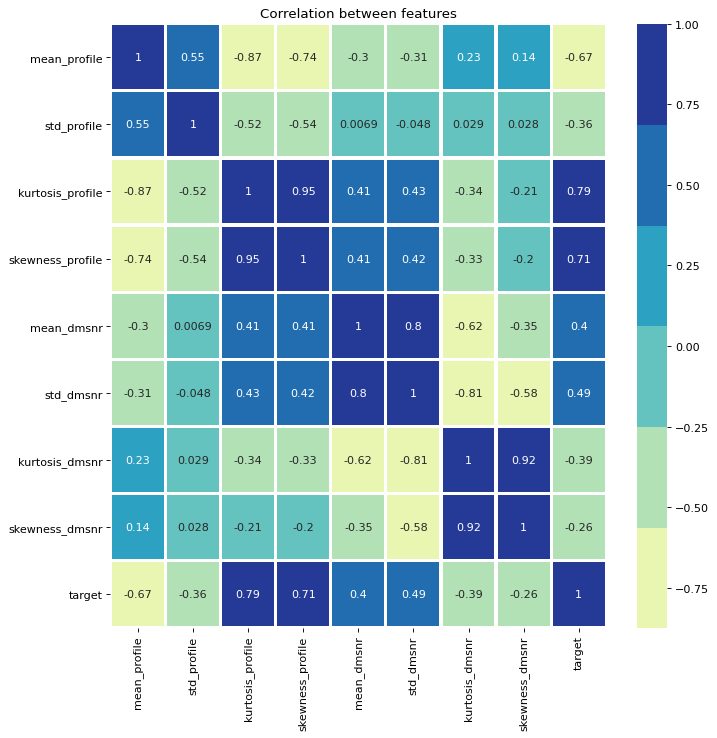

In [5]:
#@title #####> Click here to show code

corr = dataset.corr(method='pearson')
plt.figure(figsize=(10,10), dpi=80)
sns.heatmap(corr,annot=True,
            cmap=sns.color_palette("YlGnBu"),
            linewidth=2,edgecolor="k")
plt.title("Correlation between features")
plt.show()

The line of $1$'s going from the top left to the bottom right is the main diagonal, which shows that each variable always perfectly correlates with itself. This matrix is symmetrical, with the same correlation that is shown above the main diagonal being a mirror image of those below the main diagonal.


From the matrix the following statements can be made:
* *kurtosis_profile* and *skewness_profile* have very similar coefficients, leading to the conclusion that one of them could be removed. Also, they are positively correlated, with a coefficient value of $0.95$

* the features *mean_profile* and *std_profile*, such as *mean_dmsnr* and *std_dmsnr* are positively correlated. 

* the features referring to the skewness and kurtosis (of both the integrated profile and the DM-SNR) are negatively correlated to the respective mean and standard deviation. For instance, the correlation coefficient between *kurtosis_dmsnr* and *mean_dmsnr* is $-0,62$ and the one between *kurtosis_profile* and *mean_profile* is $-0.87$


In [6]:
#@title #####> Click here to show code

dataset_corr = dataset.corr()['target'][:-1] # -1 because the latest row is target
golden_features_list = dataset_corr[abs(dataset_corr) > 0.5].sort_values(ascending=False)
print("There are {} strongly correlated values with target:\n{}".format(len(golden_features_list), golden_features_list))

There are 3 strongly correlated values with target:
kurtosis_profile    0.791592
skewness_profile    0.709526
mean_profile       -0.673187
Name: target, dtype: float64


## *Pair Plot between all features*

The following plot shows both distribution of single variables and relationships between two variables. In particular, violet color is used for class 0 (non-pulsar signals) while green is used for class 1 (pulsar signal).

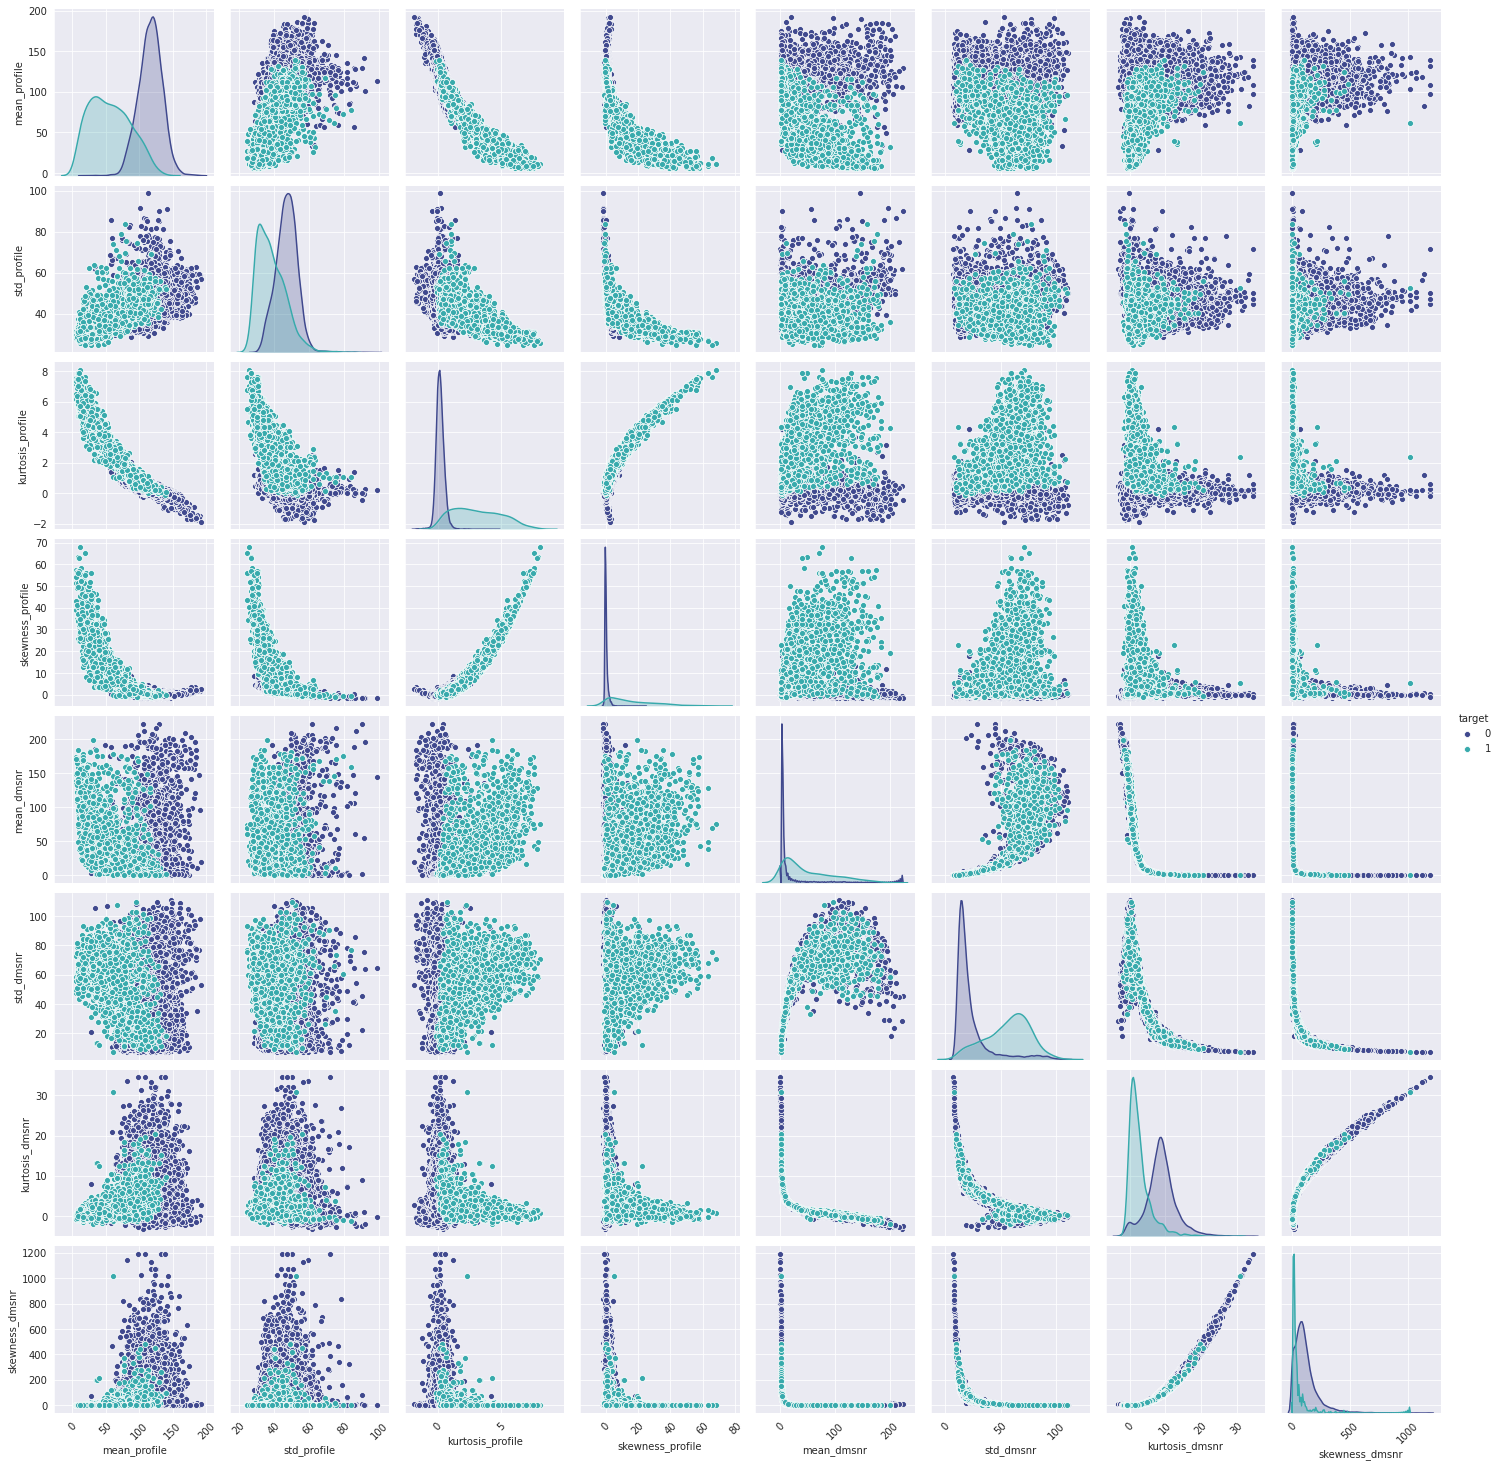

In [7]:
#@title #####> Click here to show code

with sns.axes_style("darkgrid"):

  g = sns.pairplot(dataset[["mean_profile", "std_profile", "kurtosis_profile", "skewness_profile",
                            "mean_dmsnr", "std_dmsnr", "kurtosis_dmsnr", "skewness_dmsnr", "target"]],
                  hue="target", 
                  #diag_kind="hist",
                  palette= 'mako'      
                  )
  
  for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

Looking at the pair plots, we can confirm the fact that *kurtosis_profile* and *skewness_profile* are positively correlated (their coefficient was $0.95$).
We can do the same reasoning with the attributes *kurtosis_dmsnr* and *skewness_dmsnr*: in the pair plot above they show a linear trend (their coefficient was $0.92$).

We can also notice that attributes like *kurtosis_profile*, *std_profile*, *mean_profile* are quite well separated from all the other attributes.

## *Target distribution*

Then we visualize how the target variable is distributed: there are 16259 negative examples and 1639 positive examples.

Here we can clearly see that the dataset is highly imbalanced. Non pulsar signals examples are more than 90% of the dataset. **An oversampling method may be needed** in order to build a classifier that is not biased towards the majority class.

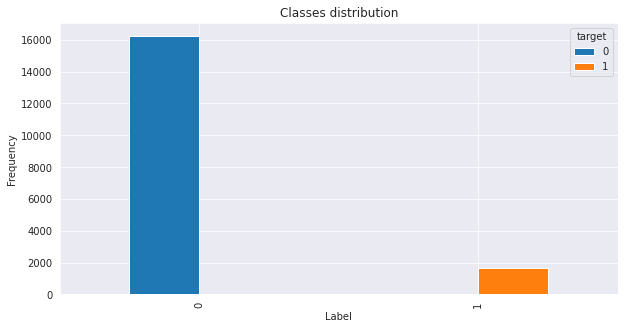

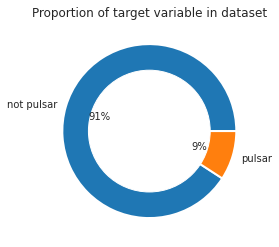

In [8]:
#@title #####> Click here to show code

with sns.axes_style("darkgrid"):
  size = len(dataset.columns)
  val='target'
  pd.crosstab(dataset[val],dataset.target).plot(kind="bar",figsize=(10,5) )
  plt.title('Classes distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')
  plt.show()



  plt.pie(dataset["target"].value_counts().values,
          labels=["not pulsar","pulsar"],
          autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
  my_circ = plt.Circle((0,0),.7,color = "white")
  plt.gca().add_artist(my_circ)
  plt.subplots_adjust(wspace = .2)
  plt.title("Proportion of target variable in dataset")
  plt.show()

## *Histograms*






The histogram is a graphical display of the distribution of a quantitative variable. It plots the number of observations that fall in intervals of values.


When examining the distribution of a quantitative variable, one should describe the overall pattern of the data (shape, center, spread), and any deviations from the pattern (outliers).
When describing the shape of a distribution, one should consider:
* Symmetry/skewness of the distribution
* Peakedness (modality) — the number of peaks the distribution has.

Outliers are data points that fall outside the overall pattern of the distribution and need further research before continuing the analysis.



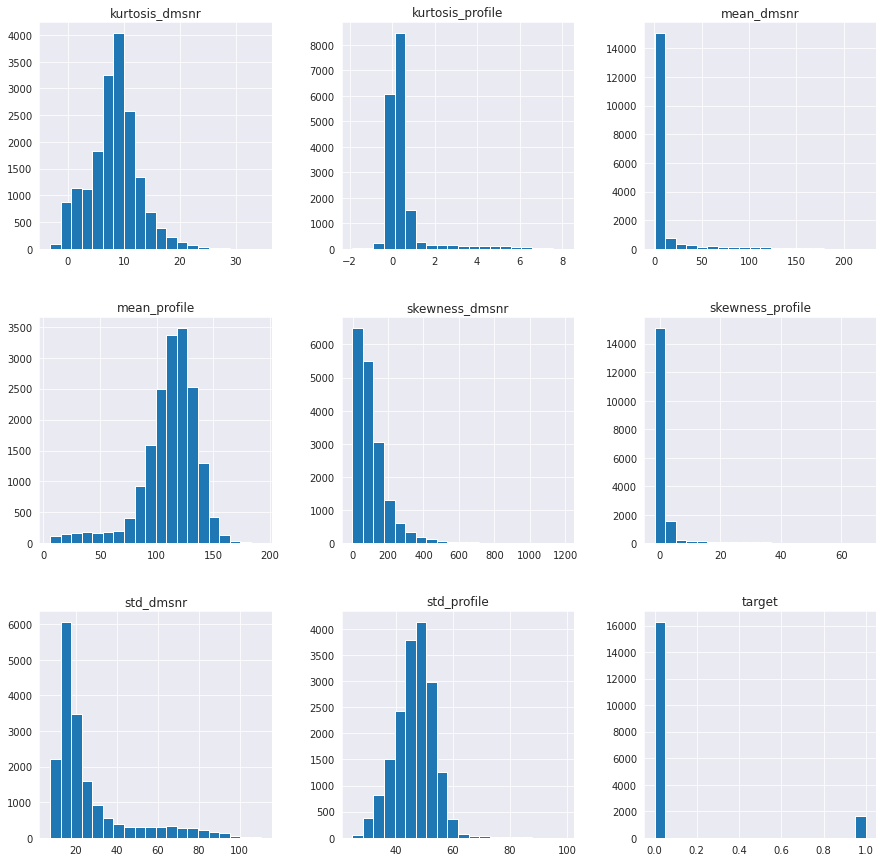

In [9]:
#@title #####> Click here to show code

with sns.axes_style("darkgrid"):

  pd.DataFrame.hist(dataset, figsize = [15,15], bins=20)
  plt.show()

Looking at the histograms, we can notice that:

* All features are unimodal (they have one mode around which the observations are concentrated)
* Most of the attributes (*kurtosis_dsmnr*, *kurtosis_profile*, *std_dsmnr*) seem to be skewed right: a distribution is called skewed right if the right tail is much longer than the left tail. 
* The spread (variability) of the distribution of the attributes differ a lot from one another. 
For instance, the attribute *kurtosis_profile* ranges from $[-2,8]$ and the attribute *skewness_dmsnr* ranges from $[0, 1200]$. **A data standardization phase is needed** in order to change the scale in which I represent the data and avoid the situation in which the algorithms would be biased towards feature with higher magnitude. In particular, I decided to perform the *z-score normalization* that consists in centering the data by subtracting the sample mean and normalize them to unit variance by dividing for the sample standard deviation.

## *Boxplots*

Then we can plot the boxplot of each feature with respect to each class. Plotting the boxplot is also useful because in this way I can also have an indication of where outliers are located.

<h2><i>What is a Boxplot?</h2></i>

A box plot is used to visually show the distribution of numerical data and skewness through displaying the data quartiles (or percentiles) and averages. 
In particular they show:
* the **minimum score**: it is the lowest score, excluding outliers;
* the **first (lower) quartile**: 25% of scores fall below the lower quartile value (also known as the first quartile);
* the **median**: it marks the mid-point of the data and is shown by the line that divides the box into two parts (sometimes known as the second quartile). Half the scores are greater than or equal to this value and half are less;
* the **third (upper) quartile**: 75% of the scores fall below the upper quartile value (also known as the third quartile). Thus, 25% of data are above this value;
* the **maximum score**: it is the highest score, excluding outliers (shown at the end of the right whisker).

![picture](https://drive.google.com/uc?export=view&id=1Gr2cWRpd7dZbwOO3tarsdav3VX6nzT9T)

The box plot shape will show if a statistical data set is normally distributed or skewed.

* When the median is in the middle of the box, and the whiskers are about the same on both sides of the box, then the *distribution is symmetric*.

* When the median is closer to the bottom of the box, and if the whisker is shorter on the lower end of the box, then the *distribution is positively skewed* (skewed right).

* When the median is closer to the top of the box, and if the whisker is shorter on the upper end of the box, then the *distribution is negatively skewed* (skewed left).

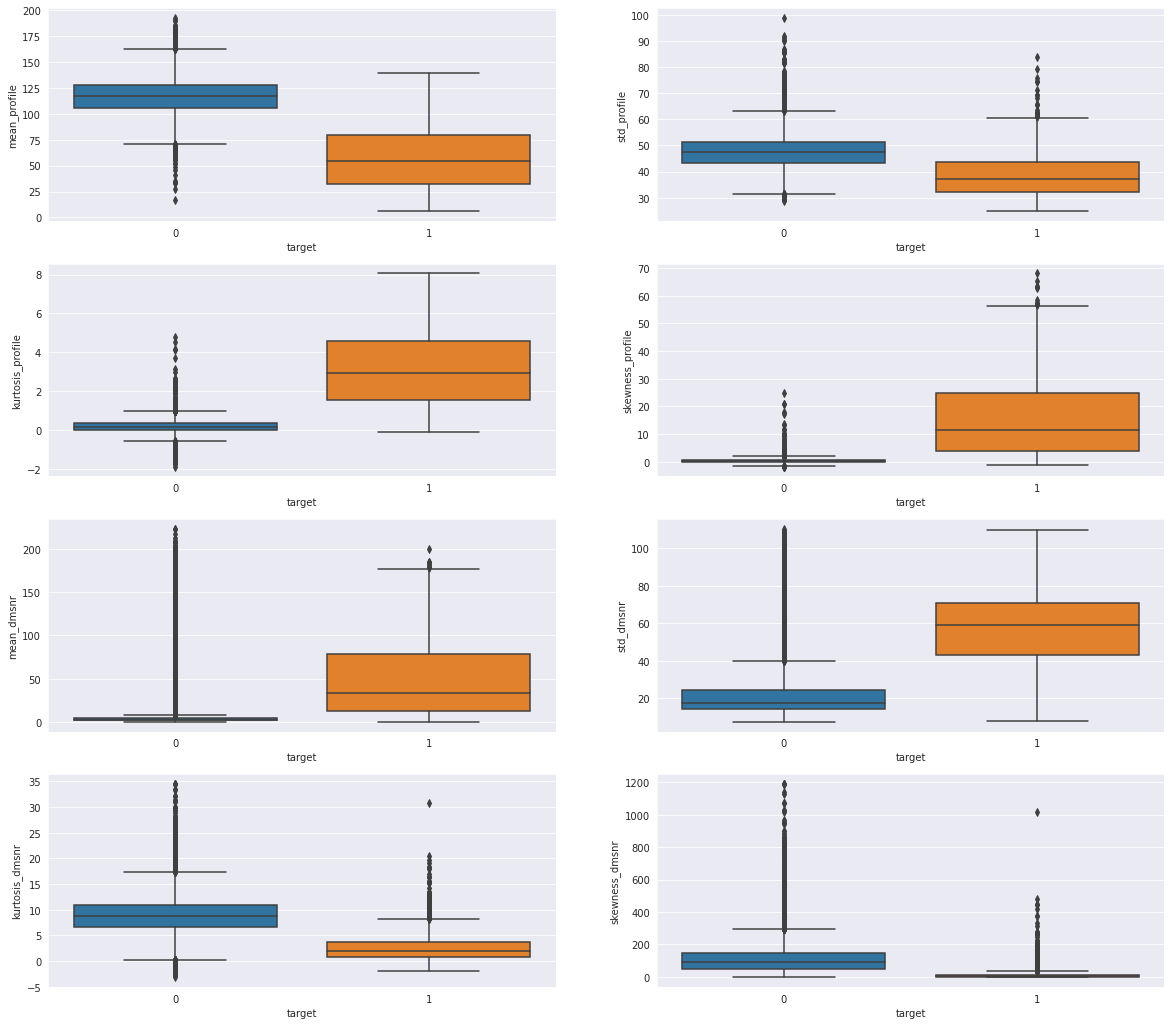

In [10]:
#@title #####> Click here to show code

with sns.axes_style("darkgrid"):
  plt.figure(figsize=(20,18))
  for i in range(8):
    plt.subplot(4,2,i+1)
    sns.boxplot(data=dataset, y=dataset.columns[i], x="target")
  plt.show()

Taking into account the fact that *class 0* represents non pulsar signals while *class 1* is for pulsars, first thing to notice is that for all the features the medians of class 0 and class 1 are quite different from each other, in fact the two distributions do not overlap.

Outliers are clearly visible from the boxplot, especially for non-pulsar signals.

Finally we can notice that some features (*std_dsmnr*, *mean_dsmnr*, *skewness_profile*) show a skewed distribution. Let's take a look at the violin plots and at the histograms to have a more accurate understanding:




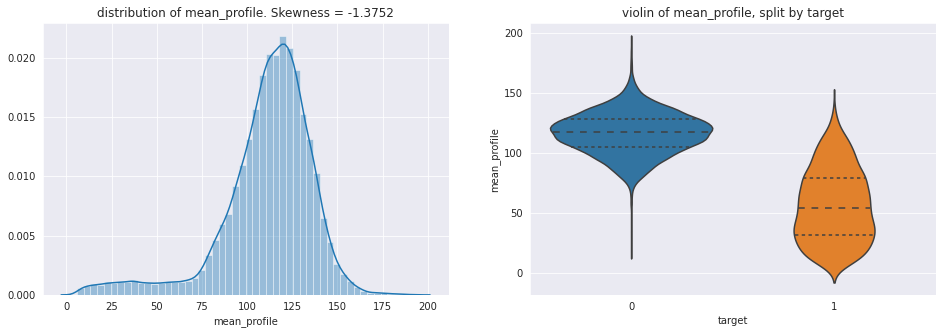

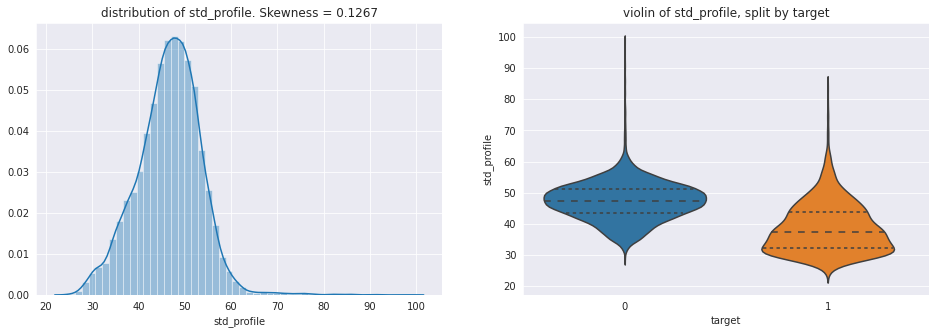

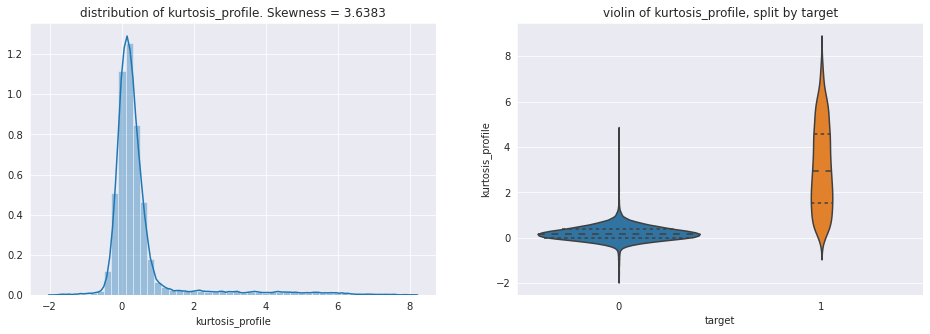

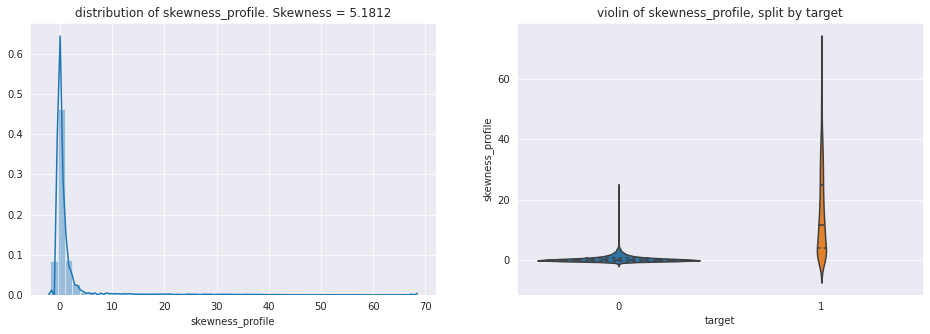

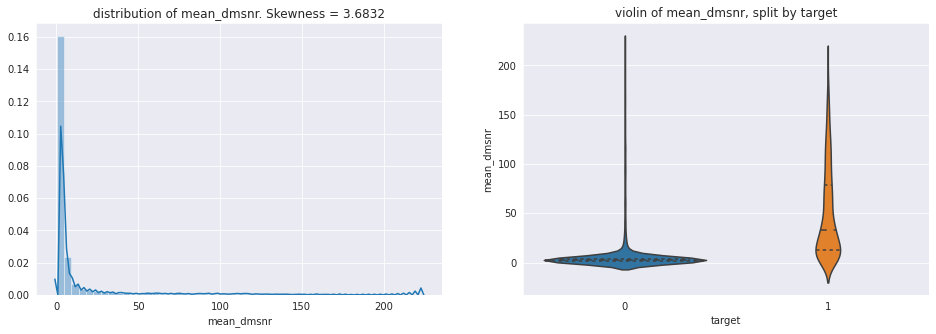

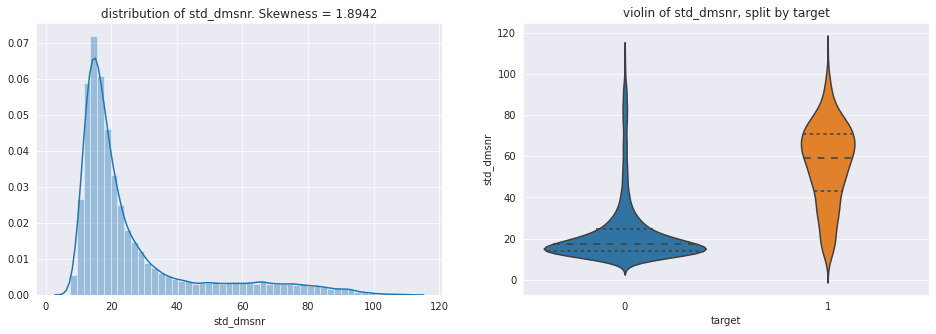

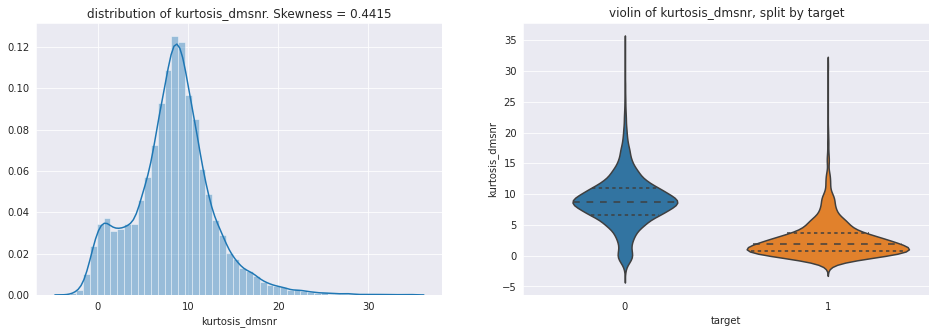

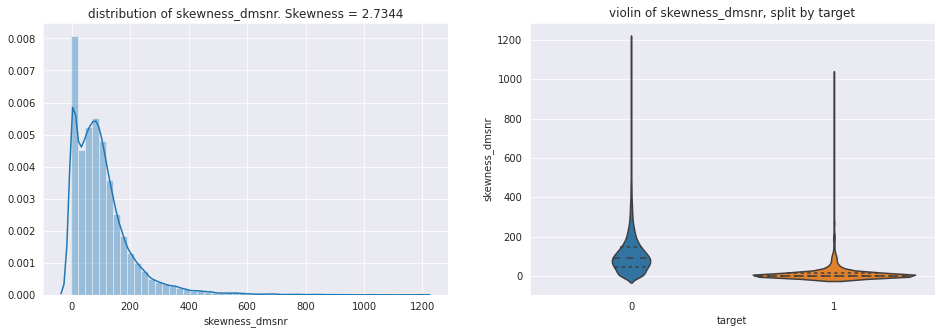

In [11]:
#@title #####> Click here to show code


# plot distributions
def plot_dists(df, col_1, col_2='target'):
    fig, axis = plt.subplots(1, 2, figsize=(16, 5))
    
    sns.distplot(df[col_1], ax=axis[0])
    axis[0].set_title('distribution of {}. Skewness = {:.4f}'.format(col_1 ,df[col_1].skew()))
    
    sns.violinplot(x=col_2, y=col_1, data=df, ax=axis[1], inner='quartile')
    axis[1].set_title('violin of {}, split by target'.format(col_1))
    plt.show()
    
for col in dataset.columns[:-1]:
  with sns.axes_style("darkgrid"):
    plot_dists(dataset, col)

It's crystal clear that we have a lot of outliers. They are quite continuous in the tails so we can look at them not as erroneous records, but as rarer observations that still carry some information.

# STANDARDIZATION

Since we noticed from the histograms that the variability of the features differs a lot from one another, a data standardization phase is needed. In particular, we decided to use **z-score normalization**.
The features are rescaled such that they have properties of a standard normal distribution with mean zero and standard deviation of one.

## $ z= \frac{x-\mu}{\sigma}$  
with mean $\mu = \frac{1}{n}\sum_i^nx_i$ and variance $\sigma = \sqrt{\frac{\sum_{i=1}^n(x_i-{\mu})^2}{n}}$



Also, standardization is important because many ML algorithms require features to be normalized (e.g. KNN, SVM, logistic regression).
When we perform PCA, the features have to be normalized before fitting the model: Principal Component Analysis is interested in the features that maximize the variance so the scale of the attributes must be the same.

In particular, we perform **standardization** using the *StandardScaler* from the *sklearn* library.


```
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
```

To give an example of its behavior, standardization here is performed on all the dataset: the model will be fitted later on with the train dataset.


In [12]:
#@title ##### Mean and Std Deviation of dataset before Standardization 

dataset.describe().loc[['mean','std'],:]


,mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
mean,111.078321,46.549021,0.477897,1.770417,12.614926,26.326918,8.303574,104.859419,0.09158
std,25.652705,6.843040,1.064056,6.168058,29.473637,19.471042,4.506217,106.517270,0.28844


In [7]:
#@title ##### Mean and Std Deviation of dataset after Standardization 

scaler = StandardScaler()

#create a copy of the original dataset
dataset_std = dataset.copy()

#fit + transform
scaler.fit(dataset[dataset.columns.values[:-1]])
dataset_std[dataset_std.columns.values[:-1]] = scaler.transform(dataset_std[dataset_std.columns.values[:-1]], copy=True)


dataset_std.describe().loc[['mean','std'],:]

,mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,target
mean,1.018102e-16,8.629678e-16,1.204639e-16,1.884532e-16,-7.171134e-17,-9.248033e-17,2.127023e-16,-1.561334e-16,0.09158
std,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,1.000028e+00,0.28844


# DIMENSIONALITY REDUCTION

Among the possible ways of handling correlation between features, we opted for the usage of **Principal Component Analysis**. **PCA** is a dimensionality reduction algorithm that may be used whenever the number of  feature is very high. It generates new orthogonal axes by a linear combination of the original attributes. These new features are uncorrelated by definition. Another way of getting rid of the aforementioned problem, could be dropping one of the two attributes. Either solutions are possible, but **PCA** was preferred, because it significantly reduces correlation between every attribute, even if it is already low.

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.


<img src="https://drive.google.com/uc?export=view&id=1Dkz8KGFdq99SgWRkSxodXNwwOM-Yf0Wo" width="650" height="250" hspace="50">



## *How does PCA work?*

Basically, Principal Components are a new coordinate system.
We take the whole dataset (we will refer at the dataset with $B$) consisting of $D+1$ dimensions and ignore the labels such that our new dataset becomes $D$ dimensional. The idea of PCA is that data points will lie mainly in a linear subspace of dimension $d < D$ which maintains most of the variability in the data. So there will be $d$ new variables describing the subspace. These variables are called *Principal Components* and will be denoted as $u_1, u_2, ..., u_d$ and they are orthogonal linear transformations of the original variables $x_1, x_2, ..., x_D$. For instance, a Principal Component would be expressed as: $u_j = w_1^{(j)}x_1 + ... + w_D^{(j)}x_D$. <br>In particular the first PC is the one with the maximum variance and subsequent PC will take up successively smaller parts of the total variability.

Covariance matrix $S$ plays a key role in PCA: variance and oher informations about the dataset can be found inside it.
<br>$S$ is the sample covariance, which is a $D×D$ matrix and it is calculated as $S = \frac{1}{n-1} BB^T$. 
<br>We have that $S$ is symmetric, infact:

*If $B$ is any $D×n$ matrix of real numbers, then the $D×D$ matrix $BB^T$ and the $n×n$ matrix $B^TB$ are both symmetric.*

Also, we have that for each $1\leq i,j\leq D$
* the $i^{th}$ entry on the diagonal of $S$, namely $S_{ii}$, is the variance of the $i^{th}$ variable.
* The $ij^{th}$ entry of $S$, $S_{ij}$ , with $i \neq j$, is the covariance between the $i^{th}$ and $j^{th}$
variables.

Since $S$ is a symmetric matrix (meaning that $S^T=S$), it can be orthogonally diagonalized and has only real eigenvalues $\lambda_1 \geq ... \geq \lambda_D \geq 0$ with eigenvectors $u_1, ..., u_D$

The eigen vector $u_1$ points in the direction of the maximal variance  if $\lambda_1$ is the max eigenvalue of $S$ and it corresponds exactly to the first PC. All the Principal Components are constructed in this way and each is an eigenvector of $S$ and their corresponding eigenvalues satisfy $\lambda_1 \geq ... \geq \lambda_D $


***

To gain further intuition into the relationships between the points, we can use PCA to project them to a 2-dimensional space, and plot the first two principal components of each point to learn about the data:

Shape of the dataset after PCA is (17897, 2)


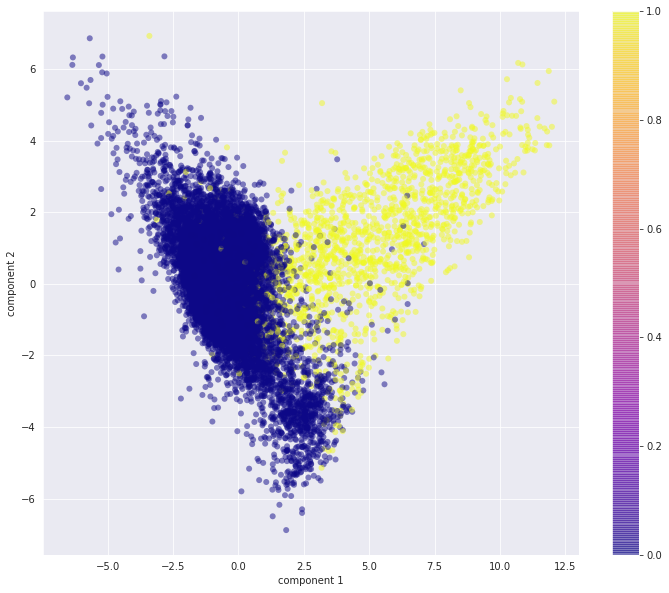

In [14]:
#@title #####> Click here to show code

#create a copy of the standardized dataset
dataset_pca2 = dataset_std.copy()
projected = dataset_pca2.drop('target', axis=1)

pca = PCA(n_components = 2)  # project from 8 to 2 dimensions
pca.fit(projected) #fit only on attributes
projected = pca.transform(projected)

#print(f"Shape of the original dataset is {dataset[:-1].shape}")
print(f"Shape of the dataset after PCA is {projected.shape}")



#plot it!
with sns.axes_style("darkgrid"):
  plt.figure(figsize=(12,10))
  plt.scatter(projected[:, 0], projected[:, 1],
              c=dataset_pca2['target'], edgecolor='none', alpha=0.5,
              cmap='plasma')
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.colorbar();

Blue color is for samples belonging to *class 0* (=non-pulsar signals) while yellow color corresponds to *class 1* (=pulsar). The full data is made of 8-dimensional points and the plot shows the projection of each data point along the directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 8-dimensional space that allows us to see the layout of the signals in two dimensions, having done this in an **unsupervised** manner that is without reference to the labels.

From the plot we can notice that even with 2 dimensions, the data points are quite well separated in the space. In addition to this, we noticed from the boxplots that the distribution of both pulsar and non-pulsar records differ a lot from each other: we expect to perform classification reaching good performances.

The plot below shows the data in 3 dimensions:


In [8]:
#@title #####> Click here to show code
import plotly.express as px

#create a copy of the standardized dataset
dataset_pca = dataset_std.copy()
X = dataset_pca.drop('target', axis=1)

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100


fig = px.scatter_3d(
    components, x=0, y=1, z=2, color = dataset['target'],
    size= [1 for i in range(len(dataset))], opacity=1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()



## *Understanding Explained Variance*

We already said that $S$ is the covariance matrix. The trace (we will refer as $T$) of $S$ is the sum of the diagonal entries of $S$, that corresponds to the sum of the variances of all the variables. $T$ is also the sum of all the eigenvalues, $T= \lambda_1 + \lambda_2 + ... + \lambda_D$. 
<br> The direction in $\mathbb{R}^D$ given by $u_1$ accounts for an amount $\frac{\lambda_1}{T}$ of the total variance, and so on.

In [16]:
#@title #####> Click here to show code


# Divide the dataset
X = dataset.drop(['target'], axis=1)
y = dataset[['target']]

# Construct the training and testing splits 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create an object of the standard scaler from sklearn
scaler = StandardScaler()
# Fit the standard scalar to the training data
scaler.fit(X_train)

# Use the transform function to normalize the data sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#create a copy of the standardized dataset
dataset_pca = X_train.copy()
X = dataset_pca.copy()


pca = PCA()
pca.fit(X)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)
fig.show()


From the plot we can see that only with 2 components the explained variance reaches very high values. In this work I decided to keep a number of principal components that would have been able to explain at least $95\%$ of the total variance so the number of new features is 5.

Here we use the model:

```
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
```
of the *Sklearn* library that expects as input the standardized dataset. PCA generates 5 new features which are uncorrelated and this is clearly evident if we take a look at the correlation matrix:


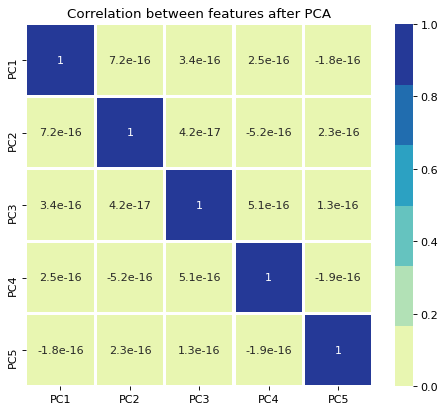

In [17]:
#@title #####> Click here to show code

#create a copy of the standardized dataset
dataset_pca = dataset_std.copy()
X = dataset_pca.drop('target', axis=1)

pca = PCA(n_components=5)
X = pca.fit_transform(X)
df_pca = pd.DataFrame(data=X, columns=["PC1","PC2","PC3","PC4", "PC5"])

#plot it!

corr = df_pca.corr(method='pearson')
plt.figure(figsize=(7,6), dpi=80)
sns.heatmap(corr,annot=True,
            cmap=sns.color_palette("YlGnBu"),
            linewidth=2,edgecolor="k")
plt.title("Correlation between features after PCA")
plt.show()

# OVERSAMPLING

So far we have seen from the plot of the target distribution that the dataset is highly unbalanced: 91% of the records belong to *class 0*, while 9% are from *class 1*. In these situations an oversampling method may be useful in order to *build a classifier that is not biased*: due to the disparity of classes in the variables, the algorithm would tend to categorize into the class with more instances, giving the false sense of a highly accurate model. 


<img src="https://drive.google.com/uc?export=view&id=10rLY_rjwoKmuz1SA_GnF7sTkV1YIhK3A" width="500" height="250" hspace="200">


To avoid this problem I decided to perform a particular technique called $SMOTE$ (Synthetic Minority Over-sampling Technique) which is known to be very efficient on datasets which have this high degree of unbalance and when points belonging to different classes lay in non-overlapping regions of the space.


$SMOTE$ first selects a minority class instance $a$ at random and finds its $k$ nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors $b$ at random and connecting $a$ and $b$ to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances $a$ and $b$.

<img src="https://drive.google.com/uc?export=view&id=1dc7fh0e_aS7hrM3hqU3VDJKub6iwP8_P" width="450" height="300" hspace="200">


In particular, $SMOTE$ was performed using the class from *imblearn* library:
```
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
```
I decided to do not set any particular value of $k$ so the default value of $k=5$ will be used.

An important thing that has to be underlined is that I decided to apply the **oversampling technique** to each fold of the dataset generated **during the cross-validation phase**: this is the only way in which I can train my model with a balanced training dataset and test it with an unbalanced test set.




# BUILDING THE MODEL

The HTRU dataset was split into training and test set with a proportion 75:25

After applying standardization to the training dataset, K-Fold Cross-Validation was performed with the following models:
* K Nearest Neighbors
* SVC with linear kernel
* SVC with RBF kernel
* Decision Trees
* Random Forest
* Logistic Regression

The models were fitted on different versions of the dataset:
* Standardized dataset
* Standardized dataset + $PCA(k=5)$
* Standardized dataset + $SMOTE$
* Standardized dataset + $PCA(k=5)$ + $SMOTE$



## *Metrics*



Since we are performing a *classification task*, we have to define the metrics in order to evaluate the classification.
For instance, in a **supervised learning** scenario like the one we are examining, we first fit/train a model on the training data $X\_train$, then test the model on $X\_test$. Then we compare the model's predictions to the true labels and we will have a count of *correctly matched* and a count of *incorrect matches* but all the matches do not hold equal value in reality, therefore we will need more then a single metric to evaluate our predictions.

The **confusion matrix** provides an insightful picture: it shows which classes are being predicted correctly and incorrectly, and what type of errors are being made. Here, the abbreviations stand for:
* *True Positive* (TP): observation is positive and is predicted to be positive
* *False Negative* (FN): observation is positive but is predicted negative
* *True Negative* (TN): observation is negative and is predicted to be negative
* *False Positive* (FP): observation is negative but is predicted to be positive

<img src="https://drive.google.com/uc?export=view&id=1TDrevT5uaNWwca9c-yO05RcU-eXifL5E" width="450" height="200" hspace="50">
  <figure>
  <figcaption>Confusion Matrix for a 2-class classification problem </figcaption>
</figure>

The equations of the 4 key evaluation metrics are:


<h2><i> Accuracy </i></h2>
It is calculated as $accuracy = \frac{TP+TN}{TP+TN+FP+FN}$ and it is the total number of correct predictions divided by the total number of predictions made for a dataset.

<h2><i> Precision </i></h2>
It is calculated as $precision = \frac{TP}{TP+FP}$ and it is the ratio of True Positives to all the positives predicted by the model.

<h2><i>Recall </i></h2>
It is calculated as $recall = \frac{TP}{TP+FN}$ and it is the ratio of True Positives to all the positives in your Dataset.

<h2><i>F1-score </i> </h2>
It is calculated as $F1 = 2*\frac{recall*precision}{recall+precision}$ and it provides a single score that balances both the concerns of precision and recall in one number. A good F1 score means that you have low false positives and low false negatives, so you’re correctly identifying real threats, and you are not disturbed by false alarms. An F1 score is considered perfect when it’s 1, while the model is a total failure when it’s 0.




##*Cross Validation*



**Cross-validation** is a resampling procedure used to evaluate machine learning models on a limited data sample.
This method refits a model of interest to samples formed from the training set, in order to obtain additional information about the fitted model.

Idea is to randomly divide the data into $K$ equal-sized parts. We leave out part $k$, fit the model to the other
$K-1$ parts (combined), and then obtain predictions for the left-out $k^{th}$ part. This is done in turn for each part $k = 1,2,...K$ and then the results are combined.
The procedure is often called k-fold cross-validation.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

Besides, when the algorithm treated has more than one hyperparameter, the configurations of hyperparameters tested are generated by means of a **Grid Search**.


<img src="https://drive.google.com/uc?export=view&id=1znzYMlSHZMFiULW7MlWyKJsrdmTyPnaX" width="650" height="450" hspace="100">

In [18]:
#@title #####> Click here to show code

# Divide the dataset
X = dataset.drop(['target'], axis=1)
y = dataset[['target']]

# Construct the training and testing splits 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Create an object of the standard scaler from sklearn
scaler = StandardScaler()
# Fit the standard scalar to the training data
scaler.fit(X_train)

# Use the transform function to normalize the data sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




def searchHyper(pipeline, grid, X_train, y_train):
  gsCV = GridSearchCV(pipeline, param_grid = grid, scoring='f1_weighted', 
                      verbose = 0, cv=5, n_jobs=-1)
  gsCV.fit(X_train, y_train)

  print()
  print(f"Best parameters set found on development set: {gsCV.best_params_}")

  return gsCV 


def applyModel(gsCV):  
  print("Detailed classification report:")
  y_pred = gsCV.best_estimator_.predict(X_test)
  print(classification_report(y_test, y_pred))
  print()

  #F1 score
  f1 = f1_score(y_test, y_pred, average='weighted')
  print(f"F1-score is: {f1}")

  #plot confusion matrix
  plt.figure(figsize=(10,7))
  sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.1f', cmap=sns.color_palette("Blues", 25))
  plt.show()


# KNN

The **K-Nearest Neighbors** algorithm is a supervised learning algorithm that is often used for classification. It is based on the idea that samples belonging to the same class are close to each other.

In this work we'll use the Euclidean distance as metric. It is defined as:
<br>
given two points $X, Y \in \mathbb{R}^n$, the distance is ${\sqrt{\sum _{k=1}^{n}{(x_{k}-y_{k})^{2}}}}$.<br>


$KNN$ is a *lazy learning algorithm* because it does not have a specialized training phase and uses all the data for training while classification. It is also a *non-parametric learning algorithm* because it doesn’t assume anything about the underlying data.

During classification, the algorithm follows these steps:
1. Choose the value of $K$ (the number of nearest data points): it can be any integer.

2. For each point $C$ in the test data do:
  * Calculate the distance between test data $C$ and each point of training data, say $X$, based on the distance metric we defined and store the result;
  * Based on the distance value, sort the distances in ascending order;
  * Consider the first $K$ computed distances;
  * Assign a class to the test point based on majority voting.

<img src="https://drive.google.com/uc?export=view&id=1ky6rX4glaJvDCkAuIAC5mfbWT2SFX1By" width="400" height="200" hspace="100">

## *Importance of parameter K*
In *KNN*, decision boundaries change along with the parameter $K$; in fact we can think of $K$ as controlling the shape of the decision boundary.
<br>As stated before, $K$ in KNN is a parameter that refers to the number of nearest neighbors to include in the majority of the voting process. In particular, choosing *smaller values* for $K$ can be noisy and will have a higher influence on the result. *Larger values* of $K$ will have smoother decision boundaries which mean lower variance but increased bias; also, computationally expensive. 
<br>For KNN models, complexity is determined by the value of $K$ (lower value = more complex).








In [19]:
#@title #####> Click here to show code


#make pipeline for PCA + SMOTE + KNN
pipeline_pca_smt_knn = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', KNN())
                     ]) 
#make pipeline for  SMOTE + KNN
pipeline_smt_knn = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', KNN())
                     ]) 
#make pipeline for PCA + KNN
pipeline_pca_knn = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', KNN())
                     ]) 
#make pipeline for KNN
pipeline_knn = imbPipeline([
                     ('classifier', KNN())
                     ]) 


# Set the parameters 
grid_pca_knn = {'classifier__n_neighbors': [3, 4, 5, 7 ]}
grid_knn = {'classifier__n_neighbors': [3, 4, 5, 7 ]}

## *KNN on Standardized dataset*


Best parameters set found on development set: {'classifier__n_neighbors': 5}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.91      0.85      0.88       410

    accuracy                           0.98      4475
   macro avg       0.95      0.92      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.978179594587287


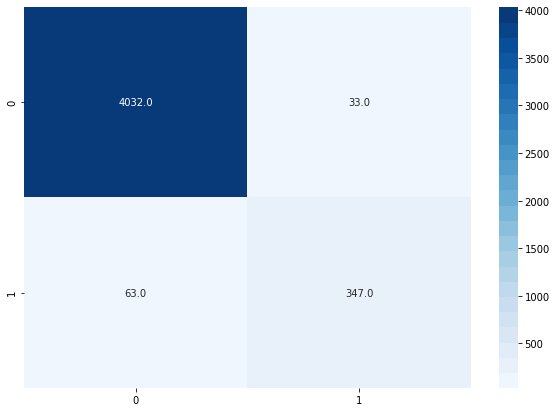

In [20]:
gsCV = searchHyper(pipeline_knn, grid_knn, X_train, y_train)
applyModel(gsCV)

## *KNN on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__n_neighbors': 5}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.91      0.83      0.87       410

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9765194594401547


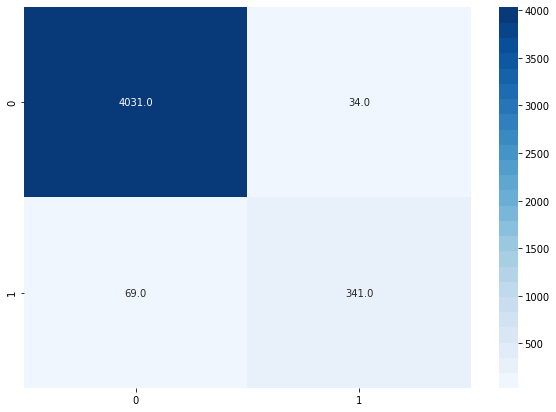

In [21]:
gsCV = searchHyper(pipeline_pca_knn, grid_pca_knn, X_train, y_train)
applyModel(gsCV)



## *KNN on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__n_neighbors': 4}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4065
           1       0.69      0.89      0.77       410

    accuracy                           0.95      4475
   macro avg       0.84      0.92      0.87      4475
weighted avg       0.96      0.95      0.96      4475


F1-score is: 0.9553325927769936


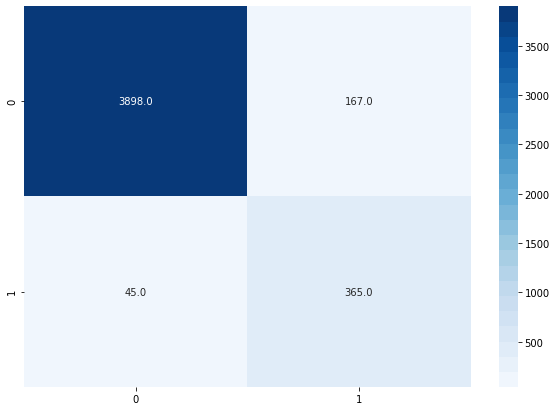

In [22]:
gsCV = searchHyper(pipeline_smt_knn, grid_knn, X_train, y_train)
applyModel(gsCV)



## *KNN on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__n_neighbors': 4}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4065
           1       0.68      0.88      0.77       410

    accuracy                           0.95      4475
   macro avg       0.83      0.92      0.87      4475
weighted avg       0.96      0.95      0.95      4475


F1-score is: 0.9534166225737453


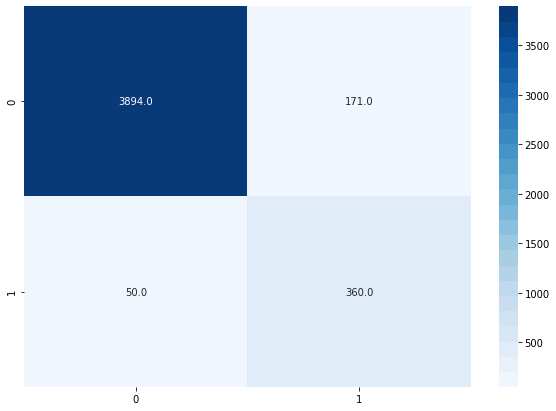

In [23]:
gsCV = searchHyper(pipeline_pca_smt_knn, grid_pca_knn, X_train, y_train)
applyModel(gsCV)


# LINEAR SVC

In this section we will explore another important model in ML: *Support Vector Machines*. The aforementioned algorithm will be approached and applied on a 2-class classification problem.

## *Support Vector Machines*

The main idea of **SVM** models is that we want to find an optimal hyperplane that separates the classes in the feature space.
<br>A *hyperplane* in $p$ dimensions is a flat affine subspace of dimension $p-1$ and it has the form $b + w_1 x_1+...+ w_p x_p = 0$ (that is equal to $<w,x>+b=0$). The vector $w = (w_1, ..., w_p)$ is called the normal vector and it points in a direction orthogonal to the surface of the hyperplane.


Among all separating hyperplanes, SVM finds the one that makes the biggest margin between the two classes. So the goal of this type of algorithm is to find the hyperplane having the **largest margin** where the margin  $\delta$  is defined as the distance of the closest example from the decision hyperplane, and the closest data-points are known as **support vectors**.


<img src="https://drive.google.com/uc?export=view&id=1ASHxSN5GoqYNhaKVaK38fyeNFSbCp3x5" width="400" height="350" hspace="150">



## *Linear separable data points*

When we want to solve a classification problem, we have a set of points $(x_i, y_i)$ that we want to classify. Here $y_i$ is the label and, since we are dealing with a binary classification problem, it can be $+1$ or $-1$. 
* Positive labelled points are in a region with response at least $+1$ 
* Negative points will lie in a region with response at most $-1$ 

These regions can be also identified with hyperplanes which are *parallel to the decision boundary*. 
<br>So we can define the **margin** explicitly in terms of these hyperplanes and, since no data are inside them, we will define the margin as the distance between them: we can think at the margin as twice the distance from the decision boundary to the nearest training point (margin = $\frac{2}{\|w\|}$). The points on the margin are called **support vectors**.

We say that the points are linearly separable if $y_i(⟨w,x_i⟩+b)>0$, for each $i=1,...,p$

Hard-SVM is the learning rule in which we select a hyperplane that separates the training set with the **largest possible margin**.
Therefore, the Hard-SVM rule is:

##### $min_w \frac{||w||^2}{2} \quad$ s.t. $y_i(⟨w,x_i⟩+b)\geq 1$$\quad$for each $i=1,..,p$

This is the *Primal Optimization Problem*, which can be rewritten in its dual form:
##### $max_{\alpha} \sum_i\alpha_i - \frac{1}{2}\sum_{i,j}\alpha_i \alpha_j y_i y_j x_i^T x_j \quad$ s.t. $\sum_i \alpha_iy_i = 0$, $\alpha_i \geq 0$$\quad$for each $i=1,..,p$

Which allows us to write $w$ as a linear combination of the support vectors.
***
##*SVM with Soft Margin*
In cases in which *linear separation is impossible* (the problem is not linear), the solution is to make the **margin soft**, adding a relaxation factor:
##### $min_{w} \frac{||w||^2}{2}+C\sum_i \xi_i \quad$ s.t. $y_i(⟨w,x_i⟩+b)\geq 1-\xi_i$ $\quad\xi_i \geq 0 \quad$ for each $i=1,..,p$

Here, the parameter $C$ is the regularization factor and together with $\xi$, which expresses the distance between the misclassified sample and the margin, it's able to allow misclassification by making the margin soft.

In particular, $C$ is the inverse of regularization strength:
* if $C$ is **big**, the model chooses a smaller-margin hyperplane;
* if $C$ is **small**, the model chooses a larger-margin hyperplane $\rightarrow$ it allows more points to be misclassified.
<img src="https://drive.google.com/uc?export=view&id=1pEHMoco74HW_dklzcvK1c58Y2JMVcW2T" width="600" height="300" hspace="50">



In [24]:
#@title #####> Click here to show code

#make pipeline for PCA + SMOTE + SVC
pipeline_pca_smt_svc = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', svm.LinearSVC())
                     ]) 
#make pipeline for  SMOTE + SVC
pipeline_smt_svc = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', svm.LinearSVC())
                     ]) 
#make pipeline for PCA + SVC
pipeline_pca_svc = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', svm.LinearSVC())
                     ]) 
#make pipeline for SVC
pipeline_svc = imbPipeline([
                     ('classifier', svm.LinearSVC())
                     ]) 

# Set the parameters 
grid_pca_svc = {'classifier__C': [ 0.1, 1, 10, 100]}
grid_svc = {'classifier__C': [ 0.1, 1, 10, 100]}



## *SVC on Standardized dataset*


Best parameters set found on development set: {'classifier__C': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4065
           1       0.83      0.87      0.85       410

    accuracy                           0.97      4475
   macro avg       0.91      0.93      0.92      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9719376906045567


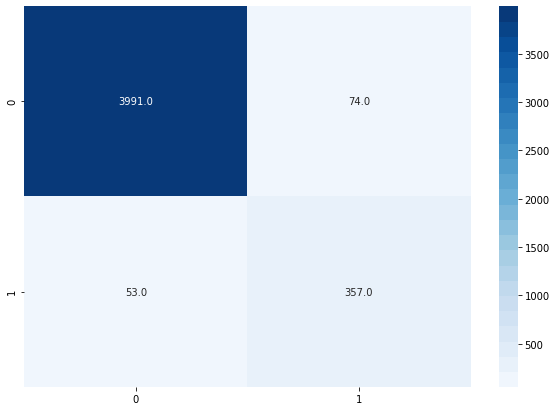

In [25]:
gsCV = searchHyper(pipeline_svc, grid_svc, X_train, y_train)
applyModel(gsCV)

## *SVC on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__C': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4065
           1       0.84      0.85      0.84       410

    accuracy                           0.97      4475
   macro avg       0.91      0.91      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9710130810991195


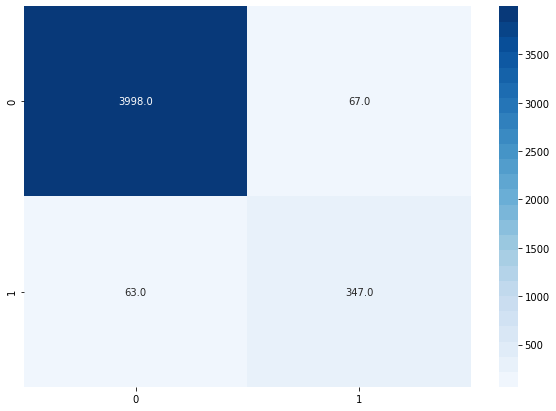

In [26]:
gsCV = searchHyper(pipeline_pca_svc, grid_pca_svc, X_train, y_train)
applyModel(gsCV)

## *SVC on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__C': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4065
           1       0.78      0.91      0.84       410

    accuracy                           0.97      4475
   macro avg       0.88      0.94      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9685156598874831


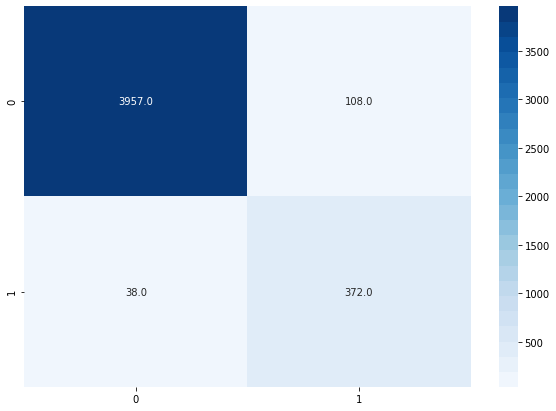

In [27]:
gsCV = searchHyper(pipeline_smt_svc, grid_svc, X_train, y_train)
applyModel(gsCV)


## *SVC on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__C': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4065
           1       0.76      0.89      0.82       410

    accuracy                           0.96      4475
   macro avg       0.88      0.93      0.90      4475
weighted avg       0.97      0.96      0.97      4475


F1-score is: 0.9658633069196757


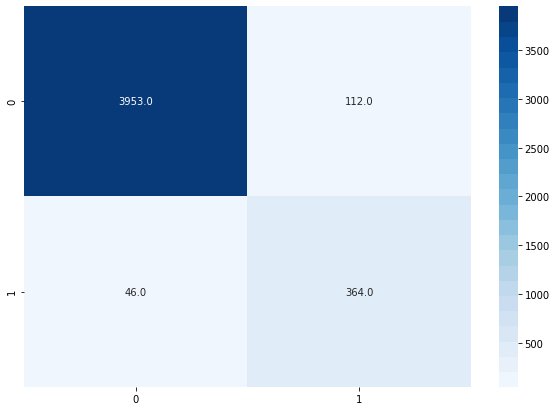

In [28]:
gsCV = searchHyper(pipeline_pca_smt_svc, grid_pca_svc, X_train, y_train)
applyModel(gsCV)


# SVC WITH KERNEL RBF

**SVM** algorithm is also known for the use of the **kernel trick**. The kernel is a way of computing the dot product of two vectors in some (very high dimensional) feature space, which is why kernel functions are sometimes called generalized dot product.

*Applying kernel trick means just to replace dot product of two vectors by the kernel function.*

We will refer to a kernel function for a mapping $\psi$ as a function that implements the inner product in the feature space and it is defined as $K(x,x')=⟨\psi(x),\psi(x')⟩$.
<br>In particular, $K(x,x')$ can be a kernel function if and only if it respects the **Mercer Theorem**: 

The Gram matrix $G_{i,j} = K(x_i,x_j)$ needs to be *positive semidefinite*, so $x^TGx\geq 0$ for each $X$ and the eigenvalues need to be *non-negative*.



<img src="https://drive.google.com/uc?export=view&id=1qPgGTSWtTCa4V6VFcLjv4DaxzpIhzsXA" width="600" height="250" hspace="50"> 

**Gaussian RBF**(Radial Basis Function) is a popular Kernel method used in SVM models. The transformation is the following:

##### $K(x,x') = e^{-\gamma||x-x'||^2}$


The SVC model with RBF kernel has non-linear boundaries, unlike the LinearSVC model which was only able to generate linear ones. This behavior is made possible thanks to the use of kernels.
Non-linear boundaries generated from $SVC(kernel=’rbf’)$ vary according to two parameters: $C$ and $\gamma$, which are tuned during 5-Fold Cross Validation. In fact, SVM with rbf kernel has a new parameter, $\gamma$: it can be thought of as the ‘spread’ of the kernel and therefore the decision region. On the other hand, parameter $C$ represents the penalty for misclassification: low values for $C$ correspond to a model which is tolerant of misclassified data point; with high values for $C$ the classifier becomes intolerant to misclassified data points.


In [29]:
#@title #####> Click here to show code

#make pipeline for PCA + SMOTE + SVC
pipeline_pca_smt_rbf = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', svm.SVC(kernel='rbf'))
                     ]) 
#make pipeline for  SMOTE + SVC
pipeline_smt_rbf = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', svm.SVC(kernel='rbf'))
                     ]) 
#make pipeline for PCA + SVC
pipeline_pca_rbf = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', svm.SVC(kernel='rbf'))
                     ]) 
#make pipeline for SVC
pipeline_rbf = imbPipeline([
                     ('classifier', svm.SVC(kernel='rbf'))
                     ]) 

# Set the parameters 
grid_pca_rbf = {'classifier__C': [ 0.1, 1, 10, 100],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_rbf = {'classifier__C': [ 0.1, 1, 10, 100],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

## *SVC with RBF kernel on Standardized dataset*


Best parameters set found on development set: {'classifier__C': 100, 'classifier__gamma': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.92      0.84      0.88       410

    accuracy                           0.98      4475
   macro avg       0.95      0.92      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9783174576848683


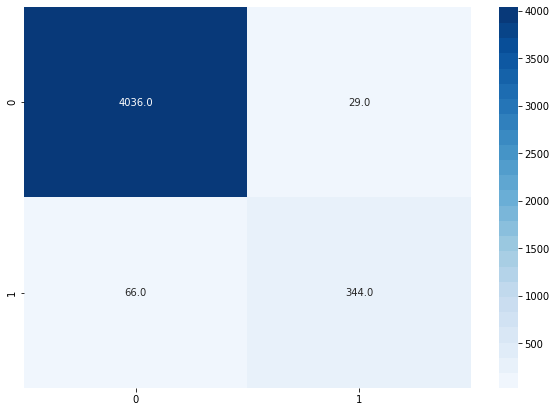

In [30]:
gsCV = searchHyper(pipeline_rbf, grid_rbf, X_train, y_train)
applyModel(gsCV)

## *SVC with RBF kernel on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__C': 100, 'classifier__gamma': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.91      0.83      0.86       410

    accuracy                           0.98      4475
   macro avg       0.94      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9758212241915717


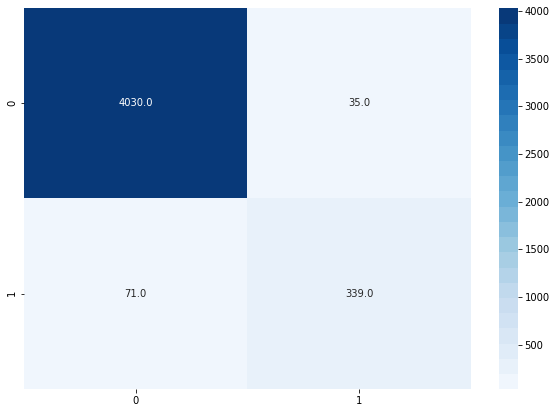

In [31]:
gsCV = searchHyper(pipeline_pca_rbf, grid_pca_rbf, X_train, y_train)
applyModel(gsCV)



## *SVC with RBF kernel on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__C': 1, 'classifier__gamma': 0.01}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4065
           1       0.81      0.91      0.85       410

    accuracy                           0.97      4475
   macro avg       0.90      0.94      0.92      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9721574370049874


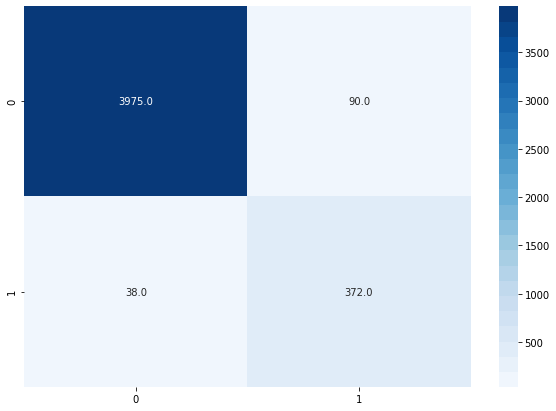

In [32]:
gsCV = searchHyper(pipeline_smt_rbf, grid_rbf, X_train, y_train)
applyModel(gsCV)


## *SVC with RBF kernel on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__C': 1, 'classifier__gamma': 0.01}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4065
           1       0.80      0.90      0.85       410

    accuracy                           0.97      4475
   macro avg       0.89      0.94      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9708236806150273


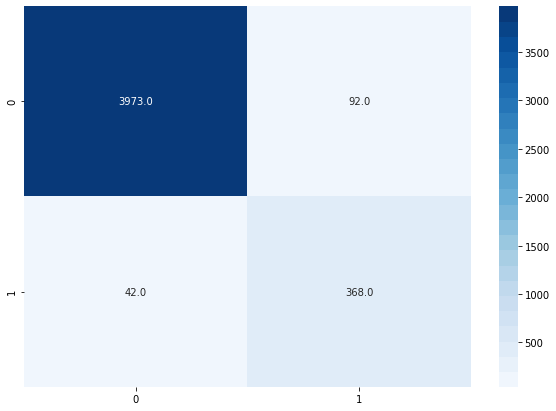

In [33]:
gsCV = searchHyper(pipeline_pca_smt_rbf, grid_pca_rbf, X_train, y_train)
applyModel(gsCV)

# DECISION TREE

**Decision Tree** is a tree-based method used for both classification and regression tasks. These methods involve stratifying or segmenting the predictor space into a number of simple regions.

*Decision Trees* used for classification are supervised learning methods and they are used to predict a qualitative response (which is, in our case, 0 and 1). Decision trees learn from data to approximate a set of if-then-else decision rules. The final result is a tree with **decision nodes** and **leaf nodes**. The deeper the tree, the more complex the decision rules and the fitter the model. 

<img src="https://drive.google.com/uc?export=view&id=1VmwYG0PmzvkhiGfd0AzL7t7EEu3hvwon" width="500" height="320" hspace="150"> 

## *How does the algorithm work?*

In a decision tree, for predicting the class of the given dataset, the algorithm starts from the root node of the tree. This algorithm compares the values of root attribute with the record attribute and, based on the comparison, follows the branch and jumps to the next node.

For the next node, the algorithm again compares the attribute value with the other sub-nodes and move further. It continues the process until it reaches the leaf node of the tree. The complete process can be better understood using the below algorithm:

1. Begin the tree with the root node, say $S$
2. Find the best attribute in the dataset using a particular **measure**
3. Divide the $S$ into subsets that contains possible values for the best attributes
4. Generate the decision tree node, which contains the best attribute
5. Recursively make new decision trees using the subsets of the dataset created in *step 3*. Continue this process until a stage is reached where you cannot further classify the nodes and called the final node as a leaf node.

Decision Tree is a **top-down** algorithm because it begins at the top of the tree and then successively splits the predictor space; it is **greedy** because at each step of the tree-building process, the best split is made at that particular step.

An optimal tree size is chosen adaptively from the training data. The recommended approach is to *build a fully-grown decision tree and then extract a nested sub-tree* (**pruneing**) in a way that you are left with a tree that compromises between purity and complexity.

In order to calculate **node impurity** and to select the right attribute on which the split is performed, we can use these **metrics**:
* **Gini Index** :  is a measure of impurity or purity used while creating a decision tree in the algorithm. An attribute with the **low Gini index** should be preferred as compared to the high Gini index. It is calculated as:
<br>$G = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$ where $k$ is the number of unique labels in that particular split and $\hat{p}_{mk}$ is the proportion of training observations in the $m^{th}$ region from the $k^{th}$ class.

* **Cross-Entropy** : it is another measure of node impurity. Like Gini index, the $m^{th}$ node is purer if the entropy $D$ is smaller. It is calculated as:
<br>$D = -\sum_{k=1}^K log(\hat{p}_{mk})$

* **Misclassification Error** : it is the fraction of the training observations in the $m^{th}$ node that do not belong to the most common class. It is calculated as:
<br>$E = 1-max_k \hat{p}_{mk}$

When growing a decision tree, Gini Index or Entropy are typically used to evaluate the quality of split.
However, for pruning the tree, Misclassification Error is used.


In [46]:
#@title #####> Click here to show code

#make pipeline for PCA + SMOTE + DT
pipeline_pca_smt_dt = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', DecisionTreeClassifier())
                     ]) 
#make pipeline for  SMOTE + DT
pipeline_smt_dt = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', DecisionTreeClassifier())
                     ]) 
#make pipeline for PCA + DT
pipeline_pca_dt = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', DecisionTreeClassifier())
                     ]) 
#make pipeline for DT
pipeline_dt = imbPipeline([
                     ('classifier', DecisionTreeClassifier())
                     ]) 

grid_dt = {'classifier__criterion': ["gini", "entropy"],
            'classifier__max_depth': [10,13, 14, 15,20]}

## *Decision Tree on Standardized dataset*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4065
           1       0.87      0.81      0.84       410

    accuracy                           0.97      4475
   macro avg       0.92      0.90      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9712173878219577


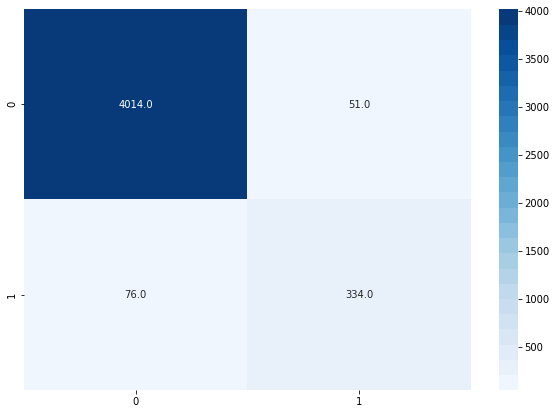

In [47]:
gsCV = searchHyper(pipeline_dt, grid_dt, X_train, y_train)
applyModel(gsCV)

##*Decision Tree on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4065
           1       0.84      0.82      0.83       410

    accuracy                           0.97      4475
   macro avg       0.91      0.90      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9694400071308825


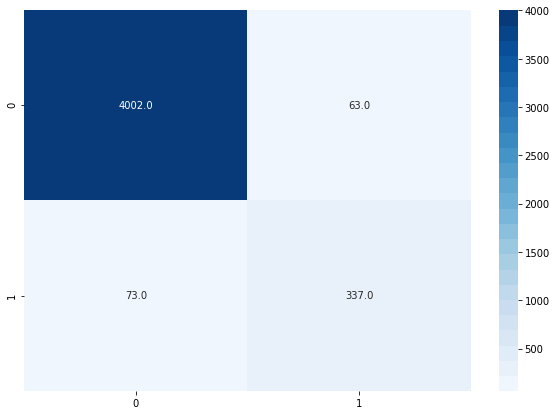

In [48]:
gsCV = searchHyper(pipeline_pca_dt, grid_dt, X_train, y_train)
applyModel(gsCV)

## *Decision Tree on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4065
           1       0.67      0.90      0.77       410

    accuracy                           0.95      4475
   macro avg       0.83      0.93      0.87      4475
weighted avg       0.96      0.95      0.95      4475


F1-score is: 0.9529655197486602


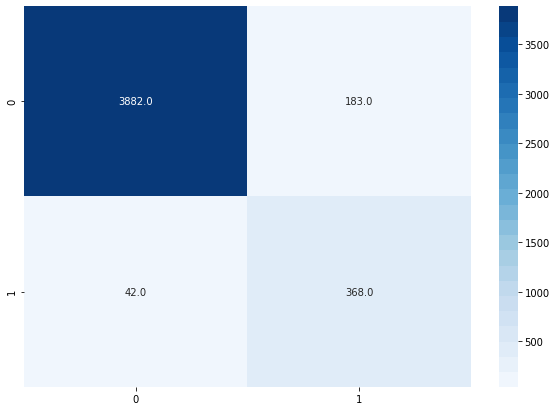

In [49]:
gsCV = searchHyper(pipeline_smt_dt, grid_dt, X_train, y_train)
applyModel(gsCV)

## *Decision Tree on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4065
           1       0.65      0.86      0.74       410

    accuracy                           0.94      4475
   macro avg       0.82      0.91      0.85      4475
weighted avg       0.95      0.94      0.95      4475


F1-score is: 0.9480087489957927


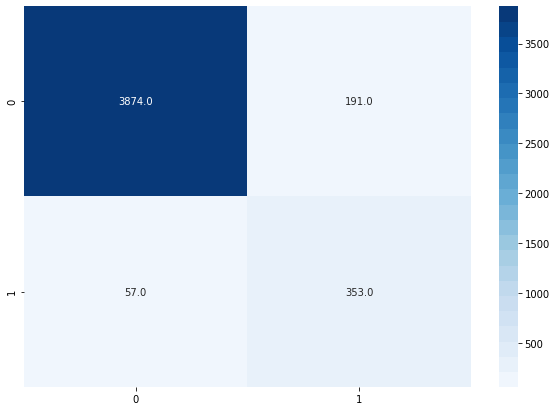

In [50]:
gsCV = searchHyper(pipeline_pca_smt_dt, grid_dt, X_train, y_train)
applyModel(gsCV)

# RANDOM FOREST

Two major limitations of decision trees are that they are prone to **overfitting**, and that they tend to be non-robust, meaning a small change in the training data results in a very different tree. **Random Forest** models overcome these two shortcomings of decision trees by generating many decision trees, and then aggregating the predictions of each individual tree to a single model prediction.

<img src="https://drive.google.com/uc?export=view&id=12G3J8apjxiW26fIpG4pvfVXXYYBnMMYB" width="750" height="550" hspace="70"> 


Random forest is an **ensemble machine learning** method that creates multiple decision trees and then combines the trees into a single model by aggregating the individual tree predictions.

To decorrelate the trees that make up a random forest, a process called **bootstrap aggregating** (also known as **bagging**) is conducted. Bagging generates new training datasets from an original dataset by sampling the original training data with replacement. This is repeated for as many decision trees that will make up the random forest. Each individual bootstrapped dataset is then used to construct a tree. 

A similar process called the random subspace method (also called attribute bagging or **feature bagging**) is also implemented to create a random forest model. 
<br>When building the decision trees, each time a split in a tree is considered, a random selection of $m$ predictors is chosen as split candidates from the full set of $p$ predictors (typically the number of new features is $m=\sqrt{p}$). The split is allowed to use only one of those $m$ predictors.
<br>This further decorrelates the trees by preventing dominant predictor variables from being the first or only variables selected to create splits in each of the individual decision trees.

The combination of bagging and the random subspace method result in a random forest model.


When a data point $x$ has to be classified, predictions from all the trees are done and the label is assigned by majority voting. 



In [56]:
#@title #####> Click here to show code

#make pipeline for PCA + SMOTE + RF
pipeline_pca_smt_rf = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', RandomForestClassifier())
                     ]) 
#make pipeline for  SMOTE + RF
pipeline_smt_rf = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', RandomForestClassifier())
                     ]) 
#make pipeline for PCA + RF
pipeline_pca_rf = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', RandomForestClassifier())
                     ]) 
#make pipeline for RF
pipeline_rf = imbPipeline([
                     ('classifier', RandomForestClassifier())
                     ]) 

grid_rf = {'classifier__criterion': ["gini", "entropy"],
            'classifier__max_depth': [5, 10, 15],
           'classifier__n_estimators': [10, 100, 500, 1000]}

## *Random Forest on Standardized dataset*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__n_estimators': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4065
           1       0.90      0.85      0.88       410

    accuracy                           0.98      4475
   macro avg       0.94      0.92      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9778282369373745


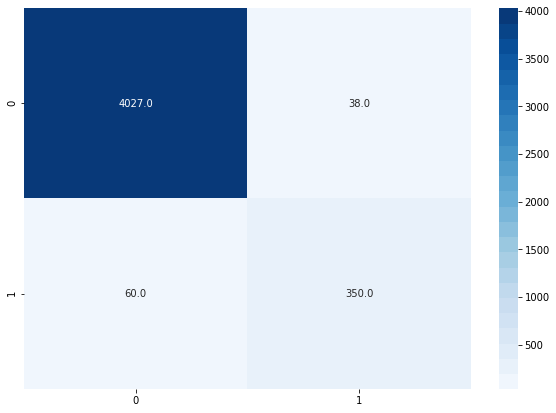

In [57]:
gsCV = searchHyper(pipeline_rf, grid_rf, X_train, y_train)
applyModel(gsCV)

## *Random Forest on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__n_estimators': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.91      0.83      0.87       410

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9765194594401547


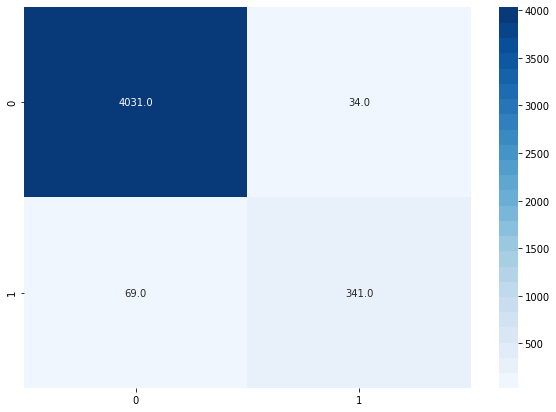

In [58]:
gsCV = searchHyper(pipeline_pca_rf, grid_rf, X_train, y_train)
applyModel(gsCV)

## *Random Forest on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__n_estimators': 500}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4065
           1       0.80      0.90      0.85       410

    accuracy                           0.97      4475
   macro avg       0.90      0.94      0.92      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9710271469306617


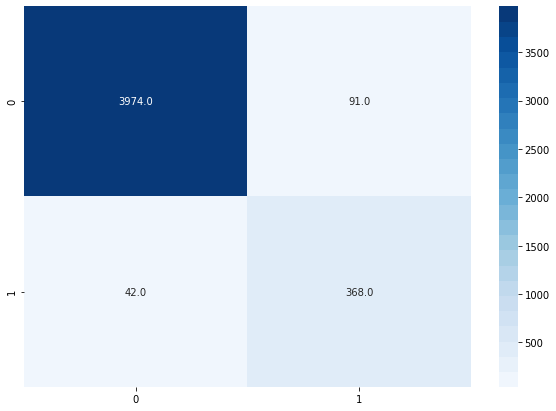

In [59]:
gsCV = searchHyper(pipeline_smt_rf, grid_rf, X_train, y_train)
applyModel(gsCV)

## *Random Forest on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__criterion': 'entropy', 'classifier__max_depth': 15, 'classifier__n_estimators': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4065
           1       0.80      0.89      0.84       410

    accuracy                           0.97      4475
   macro avg       0.89      0.93      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9699230991392622


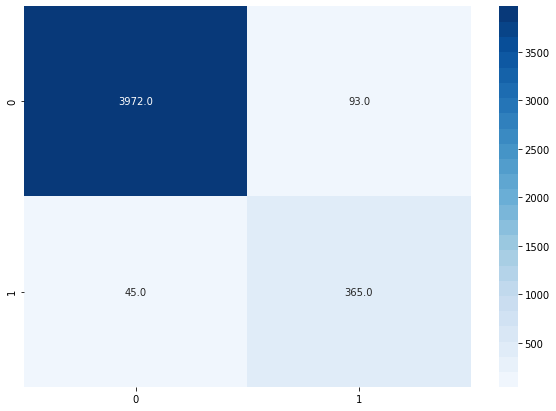

In [60]:
gsCV = searchHyper(pipeline_pca_smt_rf, grid_rf, X_train, y_train)
applyModel(gsCV)

# LOGISTIC REGRESSION



## *Linear Regression*

Before talking about Logistic Regression, I think it's useful to talk about the  the Linear model. Linear regression is the simplest statistical technique for predictive modelling analysis. It is a way to explain the relationship between a **dependent variable** (target) and one or more **explanatory variables**(predictors) using a straight line. 

In order to perform Linear Regression:
* Linearity: The relationship between X and  Y is linear.
* Homoscedasticity: The variance of residual is the same for any value of X (Constant variance of errors)
* Independence: Observations are independent of each other.
* Normality: The error(residuals) follow a normal distribution.

An example of multiple linear regression is:
<br> $Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$

To solve this equation (= we want to find the coefficients $\beta_0, \beta_1, ...$) the method of minimizing the **least squares** or the sum of squared errors is used.
It measures the squared difference between our observed value $y_i$ and our predicted value $\hat{y}_i$. Here, the error is calculated with $e = y_i - \hat{y}_i$


<img src="https://drive.google.com/uc?export=view&id=1-Z1tY7etzkRWC6TpUeRn1xQrKOOB-5hj" width="400" height="250" hspace="150"> 

***
Logistic Regression is a particular **Generalized Linear Model**. Generalized Linear Model are an extension of Linear Regression, whenever the relationship between the predictors and the dependent variables is not linear.

***
## *Logistic Regression*

When we have a classification problem, we want to predict the binary output variable Y, which can assume 2 values: either 1 or 0. This is represented by a **Bernoulli** variable.

Here, the assumption of **normality** is violated since classification is not normally distributed. 
<br>Moreover, both mean and variance depend on the underlying probability. Any factor that affects the probability will change not just the mean but also the variance of the observations, which means the variance is no longer constant, violating the assumption of  **homoscedasticity**. As a result, we cannot directly apply linear regression because it won't be a good fit.

As we are now looking for a model for probabilities, we should ensure the model predicts values on the scale from 0 to 1. A powerful model **Generalized linear model** (GLM) is suited for these situations *allowing response variables that have arbitrary distributions* (other than only normal distributions), and by using a **link function** to vary linearly with the predicted values rather than assuming that the response itself must vary linearly with the predictor. 

In Logistic Regression, we don’t directly fit a straight line to our data like in linear regression. Instead, we fit a S shaped curve, called **Sigmoid**, to our observations.

<img src="https://drive.google.com/uc?export=view&id=1GYlgA-L_2ZUi42IcHw-YPfRs8M9RA4K3" width="400" height="400" hspace="150"> 

 By computing the sigmoid function of $\beta_0 + \beta_1X$ we get a probability of an observation belonging to one of the two categories. The formula of the sigmoid function is the following:

 #### $sigmoid(x)= \frac{1}{1+e^{-x}}$

To transform the model from linear regression to logistic regression using the logistic function, we have:
<center>
 $ln(\frac{P}{1-P}) = \beta_0 + \beta_1X$

###  $\frac{P}{1-P} = e^{\beta_0 + \beta_1X}$

###  $P = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}}$

</center>
Where $P$ corresponds to the probability of success ($1$) and $1-P$ corresponds to the probability of failure ($0$). If $P$ is greater than 0.5 class 1 is assigned, otherwise, class 0 will be predicted.



In [52]:
#@title #####> Click here to show code

#make pipeline for PCA + SMOTE + LOGISTIC REGRESSION
pipeline_pca_smt_lr = imbPipeline([('pca', PCA(n_components=5)),
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', LogisticRegression())
                     ]) 
#make pipeline for  SMOTE + LOGISTIC REGRESSION
pipeline_smt_lr = imbPipeline([
                     ('smote', SMOTE(random_state=42)),
                     ('classifier', LogisticRegression())
                     ]) 
#make pipeline for PCA + LOGISTIC REGRESSION
pipeline_pca_lr = imbPipeline([('pca', PCA(n_components=5)),
                     ('classifier', LogisticRegression())
                     ]) 
#make pipeline for LOGISTIC REGRESSION
pipeline_lr = imbPipeline([
                     ('classifier', LogisticRegression())
                     ]) 

# Set the parameters 
grid_pca_lr = {'classifier__C': [0.01, 0.1, 1, 10, 100]}

grid_lr = {'classifier__C': [0.01, 0.1, 1, 10, 100]}

## *Logistic Regression on Standardized dataset*


Best parameters set found on development set: {'classifier__C': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.92      0.82      0.87       410

    accuracy                           0.98      4475
   macro avg       0.95      0.91      0.93      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9764352821423548


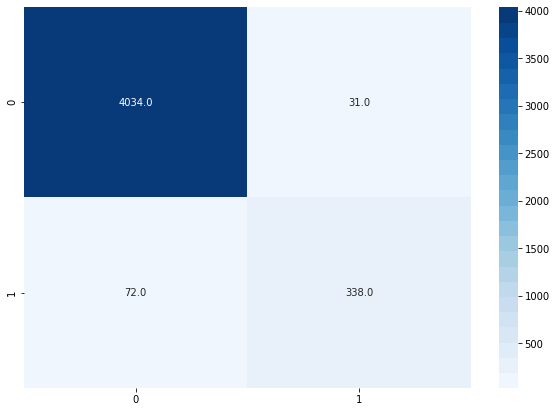

In [35]:
gsCV = searchHyper(pipeline_lr, grid_lr, X_train, y_train)
applyModel(gsCV)

## *Logistic Regression on Standardized dataset + PCA*


Best parameters set found on development set: {'classifier__C': 100}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4065
           1       0.92      0.81      0.86       410

    accuracy                           0.98      4475
   macro avg       0.95      0.90      0.92      4475
weighted avg       0.98      0.98      0.98      4475


F1-score is: 0.9756161793158965


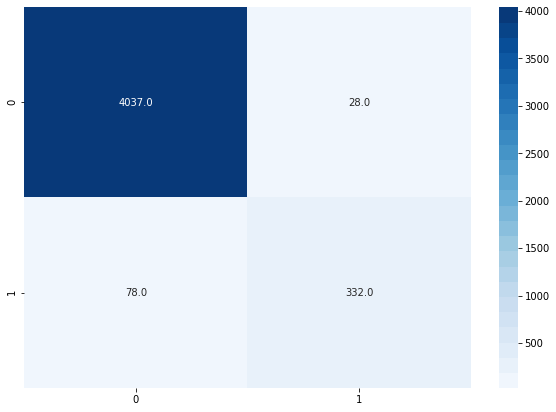

In [36]:
gsCV = searchHyper(pipeline_pca_lr, grid_pca_lr, X_train, y_train)
applyModel(gsCV)

## *Logistic Regression on Standardized dataset + SMOTE*


Best parameters set found on development set: {'classifier__C': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4065
           1       0.76      0.91      0.83       410

    accuracy                           0.97      4475
   macro avg       0.88      0.94      0.91      4475
weighted avg       0.97      0.97      0.97      4475


F1-score is: 0.9671748628613587


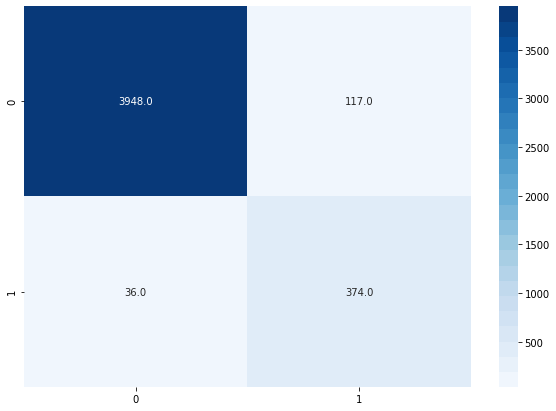

In [37]:
gsCV = searchHyper(pipeline_smt_lr, grid_lr, X_train, y_train)
applyModel(gsCV)

## *Logistic Regression on Standardized dataset + PCA + SMOTE*


Best parameters set found on development set: {'classifier__C': 0.1}
Detailed classification report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4065
           1       0.74      0.90      0.81       410

    accuracy                           0.96      4475
   macro avg       0.87      0.93      0.90      4475
weighted avg       0.97      0.96      0.96      4475


F1-score is: 0.9636111018561648


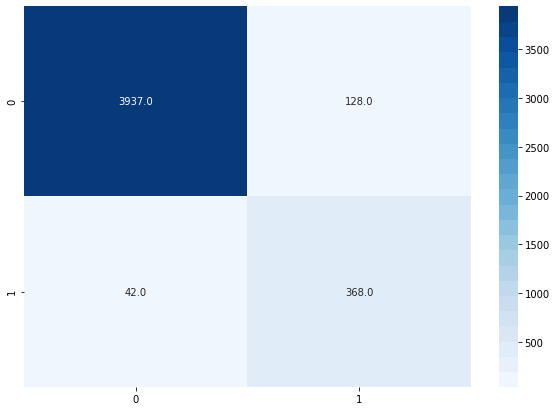

In [38]:
gsCV = searchHyper(pipeline_pca_smt_lr, grid_pca_lr, X_train, y_train)
applyModel(gsCV)

# CONCLUSION

Here is the plot referring to the F1-score obtained on the test set with all the dataset configurations and with all the models. I decided to plot only the resulting F1-score because of the unbalance in the dataset: what we are trying to achieve with the F1-score metric is to find an equal balance between precision and recall, which is extremely useful in most scenarios when we are working with imbalanced datasets.

In [3]:
#@title #####> Click here to show code

''' 
knn = [0.97817, 0.9765, 0.9553, 0.9534] 
svcL = [0.9719, 0.9710, 0.9685, 0.9658]
svcK = [0.9783, 0.9758, 0.9721, 0.9708]
dec_tree = [0.9712, 0.9694, 0.9529, 0.9480]
rand_forest = [0.9778, 0.9765, 0.9710, 0.9699]
log_reg = [0.9764, 0.9756, 0.9671, 0.9636]
'''

std = [0.97817, 0.9719, 0.9783, 0.9712, 0.9778, 0.9764]
std_pca =  [0.9765, 0.9710, 0.9758, 0.9694, 0.9765, 0.9756]
std_smt = [0.9553, 0.9685, 0.9721, 0.9529, 0.9710, 0.9671]
std_pca_smt = [0.9534, 0.9658, 0.9708, 0.9480, 0.9699, 0.9636]
x = ["knn", "LinearSVC", "SVC_RBF", "DecisionTree", "RandForest", "LogisticReg"]

import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode()

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="sum", 
                           y=std, 
                           x=x, 
                           name="std"))
fig.add_trace(go.Histogram(histfunc="sum", 
                           y=std_pca, 
                           x=x, 
                           name="std+pca"))
fig.add_trace(go.Histogram(histfunc="sum", 
                           y=std_smt, 
                           x=x, 
                           name="std+smote"))
fig.add_trace(go.Histogram(histfunc="sum", 
                           y=std_pca_smt, 
                           x=x, 
                           name="std+pca+smote"))
fig.update_yaxes(range=[0, 1])
fig.show()


ModuleNotFoundError: No module named 'plotly'

We can notice that:
* In general, with all the models, the best performances are achieved when the fitting is performed on the standardized dataset.

* The best models are **KNN** (0.9781), **SVC with RBF kernel** (0.9783) and **Random Forest** (0.9778).

* In general, we can notice that this dataset is good for its own for classification: applying $PCA$ didn't bring any significant improvement, infact we have already an handable number of dimensions and our models are not affected by the unbalance at all, so applying $SMOTE$ lead to a tiny drop in performances.